# Atmospherically Corrected Earth Engine Time Series 

### Overview

This notebook creates atmospherically corrected time series of satellite imagery using [Google Earth Engine](https://earthengine.google.com/) and the [6S emulator](https://github.com/samsammurphy/6S_emulator). 

### Supported missions

* Sentintel2
* Landsat8
* Landsat7
* Landsat5
* Landsat4

### Output

Average, cloud-*free* pixel values 

### Cloud masking

Uses standard cloud masks, i.e. FMASK for Landsat and ESA-QA60 for Sentinel 2.  There is no guarantee they will find all clouds, a discussion on more advance and/or alternative cloud masking strategies is available [here](https://groups.google.com/forum/#!searchin/google-earth-engine-developers/cloud$20AND$20sentinel2%7Csort:relevance/google-earth-engine-developers/i63DS-Dg8Sg/FWenONUFBwAJ)

#### Initialize

In [15]:
# standard modules
import os
import sys
import ee
import matplotlib
import pandas as pd
%matplotlib inline
ee.Initialize()

# custom modules
base_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(base_dir,'atmcorr'))
from kml_reader import read_kml
from timeSeries import timeSeries
from postProcessing import postProcessing
from plots import *

In [16]:
#debuggin
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### User Input

In [17]:
target = 'Yugama'
geom = read_kml('IAVCEI.kml', target)

# start and end of time series
startDate = '1985-01-01'# YYYY-MM-DD
stopDate  = '2017-01-01'# YYYY-MM-DD

# satellite missions
missions = ['Sentinel2', 'Landsat8', 'Landsat7', 'Landsat5', 'Landsat4']

### All time series
This function extracts cloud-free time series for each mission, atmospherically corrects them and joins them together

In [18]:
allTimeSeries = timeSeries(target, geom, startDate, stopDate, missions)

Loading from excel file


### Data post-processing
Resample into daily intervals using liner interpolation and calculate hue-saturation-value from RGB.

In [19]:
from postProcessing import postProcessing
data = postProcessing(allTimeSeries)

### bringing it all together...
make a pretty graph to help us do some science.

In [20]:
from plots import *
t1 = pd.datetime.strptime('1985-01-01','%Y-%m-%d')
t2  = pd.datetime.strptime('2017-01-01','%Y-%m-%d')
fieldData = load_fieldData(target, startDate, stopDate)

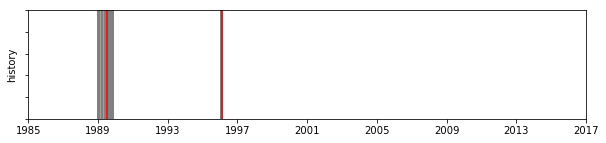

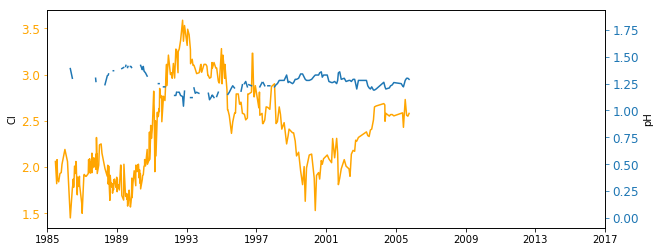

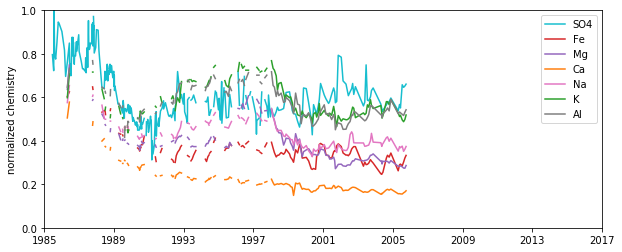

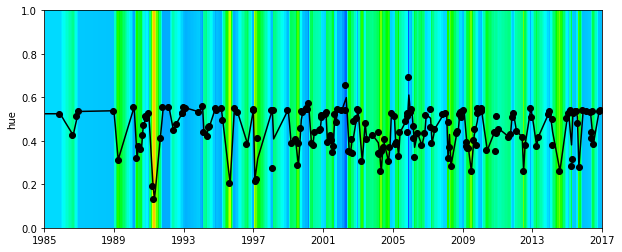

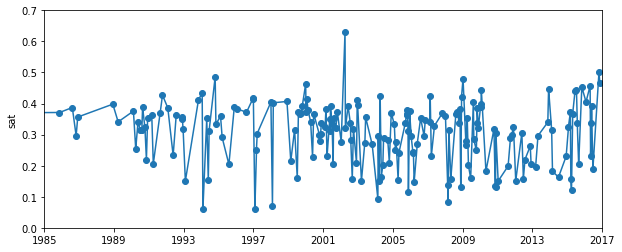

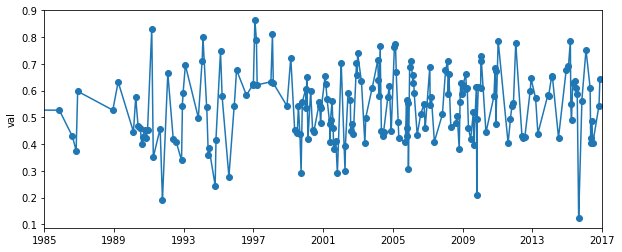

In [21]:
from plots import *
save = True
save = False
plot_history(target, fieldData, startDate, stopDate, save=save)
plot_acid(target, fieldData, t1, t2, save=save)
plot_other(target, fieldData, t1, t2, save=save)
plot_hueSticks(target, data, t1, t2, save=save)
plot_color(target, data,'sat', t1, t2, fieldData, save=save)
plot_color(target, data, 'val', t1, t2, fieldData, save=save)